In [1]:
import re, os
from datetime import datetime
import shutil
import pickle
from collections import OrderedDict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

ROOT_FOLDER = "/mnt/hgfs/projlogs/SFW/sops1/SOPS/Performance Test - Performance_Test1"
ROOT_FOLDER = "/mnt/hgfs/projlogs/SFW/hq1/Performance Test - Performance_Test1"
# MILL, POND, OPP1, OPP2, FOX
# SOPS, HQ1, BAYVIEW, FIELD1
ROOT_FOLDER = "/mnt/hgfs/projlogs/SFW/SOPS"

In [2]:
# pd.set_option('display.mpl_style', 'default')
pd.set_option('plotting.matplotlib.register_converters', 'default')
%matplotlib inline
plt.style.use('ggplot')
sns.set_color_codes("pastel")

In [3]:
class TestError():

    def __init__(self, timestamp, userid, cycleid, uj, stepid, errortype, message, test_folder):
        self.time = pd.to_datetime(timestamp, infer_datetime_format=True) 
        self.userid = userid
        self.cycleid = cycleid
        self.stepid = stepid
        self.errortype = errortype
        self.message = message
        self.test_folder = test_folder
        self.uj = uj
        
        self.cause = ''
        self.cause_message = ''
        
        if errortype == 'Success Validation Failure':
            sv = re.search(r'failed sub validations: (.+?)\) for step ".+?" was not found in the response. The response received has been written to "(.+?)"', message)
            self.validation = sv.group(1)
            self.file = sv.group(2)
            # name_parts = self.file.split('__')
            # self.uj = name_parts[0]
        else:
            self.validation = None
            self.file = None

        if errortype == 'Response DD Extraction Failure':
            ddisrc = re.search(r'Error reading value for response DD item (.+?) used in step (.+?)', message)
            self.dditem = ddisrc.group(1)
            # !!! the line below currently gives wrong value due to BUG in the ST logs.
            # self.ddi_source = ddisrc.group(2)
        else:
            self.dditem = None
    
    def show(self, shorten=True):
        if shorten:
            message = self.cause_message[:50] + (len(self.cause_message)>50)*'...'
        if self.dditem:
            message = self.dditem
        return OrderedDict([('time', self.time),
                ('user', self.userid),
#                 ('total errors', 0),
                ('uj', self.uj),
                ('step', self.stepid),
                ('cycle', self.cycleid),
                ('error type', self.errortype),
                ('error cause', self.cause),
                ('cause message/ddi', message),
               ])
    
    def set_snapshot_details(self):
        pass
        
    def _read_error_file(self):
        if self.errortype == 'Success Validation Failure':
            try:
                # for QR, log files are directly in the log folder for the run
                with open(os.path.join(self.test_folder, self.file), 'rt') as f:
                    html = f.read()
            except FileNotFoundError:
                # for non-QR, log files are in subfolders named after virtual user ids
                with open(os.path.join(self.test_folder, 'user'+self.userid , self.file), 'rt') as f:
                    html = f.read()

        return html
    
    def _set_cause(self, cause, message):
        self.cause = cause
        self.cause_message = message
        
    def determine_casuse(self):
        if self.errortype == 'Success Validation Failure':
            html = self._read_error_file()
            if html.count('<label for="username">User Name:</label>')>0:
                self._set_cause('logged off', '')
                return None

            kick_match = re.search(r'redirect><\!\[CDATA\[https*://.+?/maximo/webclient/login/logout.jsp.*?\]\]></redirect>', html)
            if kick_match is not None:
                self._set_cause('Maximo forcefully signed out the user', '')
                return None

            if html.count('title="Please wait...">Please wait...</label>')>0:
                self._set_cause('Long Op', '')
                return None
            
            if html.count("addLongOpTimeout('dolongopquerycheck()',")>0:
                self._set_cause('Long Op', '')
                return None

            if html.count('MessageWarning.png')>0:
                msg = html[html.find('MessageWarning.png'):]
                msg = '<' + msg[:msg.find('</table>')]
                msg = re.sub(r'<[^>]*?>', '', msg)
                msg = msg.replace('\n','').strip()
                self._set_cause('Warning Message', msg)
                return None

            if html.count('st_MessageQuestion.png')>0:
                msg = html[html.find('st_MessageQuestion.png'):]
                msg = '<' + msg[:msg.find('</table>')]
                msg = re.sub(r'<[^>]*?>', '', msg)
                msg = msg.replace('\n','').strip()
                self._set_cause('Question Message', msg)
                return None
            
            if html.count('st_MessageCritical.png')>0:
                msg = html[html.find('st_MessageCritical.png'):]
                msg = '<' + msg[:msg.find('</table>')]
                msg = msg[:msg.find('</component>')]                
                msg = re.sub(r'<[^>]*?>', '', msg)
                msg = msg.replace('\n','').strip()
                self._set_cause('Critical Message', msg)
                return None

            if html.count('>0 - 0 of 0')>0:
                self._set_cause('operation resulted in a table with zero rows', 'searchterm: ' + self.validation)
                return None

            break_index = html.find('---------------Response-----------------')
            html_request_only = html[:break_index]
            html_response_only = html[break_index + 40:]
            if html_response_only.count(self.validation)>0:
                self._set_cause('validation bug', 'searchterm: ' + self.validation)
                return None

            ###  --- COB specific errors ---
            if  html_response_only.count('"id":"0_APPRSS_OPTION","text":"APPRSS"') and not html_response_only.count('Approved'):
                self._set_cause('missing "Approved" option', '')
                return None

            if html_request_only.count('targetId%22%3A%22mx387') and html_response_only.count('title="1 - 2 of 2">1 - 2'):
                self._set_cause('dynamic response', 'missing reference of WO field, thus cant validate')
                return None

            if html_request_only.count('<command>ISWM-RECORDFAILUREREPORT</command>'):
                self._set_cause('response lacks confirmation of recordid', 'response lacks confirmation of recordid')
                return None   
            ### --- ==================== ---

            self._set_cause('unknown validation fail', html)
            self.html = html
        else:
            self._set_cause(self.errortype, '')


In [4]:
class Loop():
    
    def __init__(self, lead_error, lenght):
        # the start & end index, should refer to cycle index, not error index
        self.lead_error = lead_error
        self.start = int(lead_error.cycleid)
        self.end = self.start + lenght
        # the +1 is needed because both the starter and the final cycles are part of the loop
        # it shouldn't be passed in the constructor in order to properly calculate the end cycle id
        self.lenght = lenght + 1
        
    def show(self):
        return OrderedDict([('loop start', self.start), ('loop length', self.lenght),])
    
    def __repr__(self):
        return str(self.start) + '-' + str(self.end)

In [5]:
def plot_it(df, plot_params):
    df.plot(**plot_params);

In [6]:
class VirtualUser():
    
    def __init__(self, userid, start_time, uj, errors=[], loops=[], max_loop=None):
        self.userid = userid
        self.start_time = start_time
        self.uj = uj
        self.errors = errors
        self.loops = loops
        self.max_loop = max_loop
        
    # If I can user.errors.append(err) , why create a method?
    def append_error(self, error):
        self.errors.append(error)

    def process_errors(self):
        self.error_count = len(self.errors)
        
        consecutive_count = 0
        consecutiveness = ''
        max_consecutive = -1
        max_loop = -1
        # looping over errors in reverse, thus init with values of the last error in the list
        prior_error = self.errors[-1]
        for error in reversed(self.errors):
            error.determine_casuse()

            # the 1st condition needs <= instead of == because there could be multiple errors per cycleid
            # the 2nd condoition is to avoid counting the initial record as a consecutive term
            if int(prior_error.cycleid) - int(error.cycleid) <= 1 and error != self.errors[-1]:
                consecutive_count += 1
            else:
                if consecutive_count > 0:
                    new_loop = Loop(prior_error, consecutive_count)
                    self.loops.append(new_loop)
                    consecutiveness = ';' + str(new_loop) + consecutiveness

                    # update max_loop
                    if consecutive_count > max_consecutive:
                        max_consecutive = consecutive_count
                        self.max_loop = new_loop

                consecutive_count = 0
                
            prior_error = error
        
        # check if the for-ending error was completing an error-loop
        if consecutive_count > 0:
            new_loop = Loop(prior_error, consecutive_count)
            self.loops.append(new_loop)
            consecutiveness = ';' + str(new_loop) + consecutiveness

            # update max_loop
            if consecutive_count > max_consecutive:
                max_consecutive = consecutive_count
                self.max_loop = new_loop
        
        self._process_cause_stats()
        
        return consecutiveness[1:]
    
    def _process_cause_stats(self):
        causes = {}
        for e in self.errors:
            if e.cause in causes.keys():
                causes[e.cause] += 1
            else:
                causes[e.cause] = 1

        self.causes = causes
        
    def lead_error_info(self):
        # return info on the "lead" error of the longest error-loop
        #   or the first error for the user
        
        if self.max_loop:
            lead_error_info = self.max_loop.lead_error.show()
            max_loop_info = self.max_loop.show()
        else:
            lead_error_info = self.errors[0].show()
            max_loop_info = OrderedDict([('loop start', ''), ('loop length', '')])
            
        def surgery(ordered_dict, index, insertion):
            return OrderedDict(list(ordered_dict.items())[:index] + 
                               list(insertion.items()) + 
                               list(ordered_dict.items())[index+1:])
        
        lead_error_info = surgery(lead_error_info, 2, {'total errors': user.error_count})
        lead_error_info = surgery(lead_error_info, -2, max_loop_info)
            
#         lead_error_info['total errors'] = user.error_count
        return lead_error_info
    
    def show_errors(self):
        return pd.DataFrame([ z.show() for z in self.errors ])
    
    def plot_user_errors(self, period='h', plot_params=None):
#         period = {
#                   'h': lambda x: x.hour,
#                   'm': lambda x: x.minute,
#                   's': lambda x: x.second,
#                  }[period]
#         user_df = self.show_errors()
#         user_df["time"] = pd.to_datetime(user_df["time"])
#         per_hr = user_df.groupby(user_df['time'].apply(period)).user.count()
#         per_hr.plot('bar', color='b');
        
        user_df = self.show_errors()
        user_df["time"] = pd.to_datetime(user_df["time"])
        encoded_periods = {'h': 1, 'm': 2, 's': 3}
        period_list = lambda x: [x.dt.hour, x.dt.minute, x.dt.second, None][:encoded_periods[period]]
        per_period = user_df.groupby(period_list(user_df["time"])).user.count()
        if not plot_params:
            plot_params = {'kind': 'line', 'title' : 'errors per ' + period, 'figsize': (15, 9) }#  'style': ['-.'], }
        plot_it(per_period, plot_params)


Determine the number of relevant log files in the log's Run folder.

In [7]:
test_folder = ROOT_FOLDER

## Considered running simultaneous analisys of different injectors:
##    it will not work, because user ids are repeated i.e user 0006 on INJ1 will be assigned to UJ1,
##    while user 0006 on INJ2 will have different UJ, and different errors, and etc.

files = [ f for f in os.listdir(test_folder) if os.path.isfile(os.path.join(test_folder,f)) and f.find('.log.')>0 ]
files = [ f for f in files if f.find('lck')==-1 ]
print('at', test_folder, ', found', len(files), 'log files: ', files)

at /mnt/hgfs/projlogs/SFW/SOPS , found 1 log files:  ['SOPS2UA5101XHD_0.log.1']


In case of multiple log files, merge them and work with the merged file.

In [8]:
if len(files)==1:
    FNAME = files[0]
elif len(files)>1:
    print('multiple files - merging into _log.all')
    FNAME = '_log.all'
    with open(os.path.join(test_folder, FNAME), 'wb') as wfd:
        for file in files:
            with open(os.path.join(test_folder, file),'rb') as fd:
                shutil.copyfileobj(fd, wfd, 1024*1024*100)
                #100MB per writing chunk to avoid reading big file into memory.

else:
    if not FNAME:
        print('no files found - please assign FNAME manually')
        exit(1)
    

Read the log

In [9]:
print('processing file: ', test_folder + '/' + FNAME)

with open(test_folder + '/' + FNAME,'r') as f:
    alllog = f.read()

processing file:  /mnt/hgfs/projlogs/SFW/SOPS/SOPS2UA5101XHD_0.log.1


Determine test start and test end times.

In [10]:
log_times = re.findall(r'[\n^]\d\d/\d\d/\d\d\d\d \d\d\:\d\d:\d\d \[', alllog)
print('time stamps', len(log_times))
test_start_time = pd.to_datetime(log_times[0][:-2], infer_datetime_format=True)
test_end_time = pd.to_datetime(log_times[-1][:-2], infer_datetime_format=True)
print(' Test start:', test_start_time, '\n', 'Test end  :', test_end_time)

time stamps 24726
 Test start: 2018-01-29 01:42:51 
 Test end  : 2018-01-29 09:42:58


Obtain the list of errors.

In [11]:
errorlog = re.findall(r'(?<=\n).+?\[SEVERE\].+?id \d+?,[\w\s]+?\):.+?(?=\n)', alllog)
print('severe count:', len(errorlog))

severe count: 6938


Obtain the list of snapshots.

In [12]:
snap = r'<GENERAL_DATA>\n\s+?<APPLICATION>([^<]+?)</APPLICATION>\n\s+?<USER_JOURNEY>([^<]+?)</USER_JOURNEY>\n\s+?<STEP>([^<]+?)</STEP>\n\s+?<ERROR>([^<]+?)</ERROR>\n\s+?<INJECTOR_NAME>([^<]+?)</INJECTOR_NAME>\n\s+?<START_DATE>([^<]+?)</START_DATE>\n\s+?<RUN_NAME>([^<]+?)</RUN_NAME>\n\s+?<BROWSER_PROFILE>([^<]+?)</BROWSER_PROFILE>\n\s+?<DATE>([^<]+?)</DATE>\n\s+?<PROCESS_NAME>([^<]+?)</PROCESS_NAME>\n\s+?<PROCESS_NUMBER>([^<]+?)</PROCESS_NUMBER>\n\s+?<USER_ID>([^<]+?)</USER_ID>\n\s+?<CYCLE_ID>([^<]+?)</CYCLE_ID>\n\s+?<CURRENT_USERS>([^<]+?)</CURRENT_USERS>\n\s+?<CURRENT_CONNECTIONS>([^<]+?)</CURRENT_CONNECTIONS>\n\s+?</GENERAL_DATA>'

snaplog = re.findall(snap, alllog)
print('snapshots:', len(snaplog))

snapshots: 7983


In [13]:
# # Dump the snapshot list into a debug file
# with open(os.path.join(test_folder, 'snaps.dump.txt'), 'wt') as f:
#     f.write('\n'.join(map(str, snaplog)))

Parse the log file and create User and Error objects

In [14]:
errors = []
vusers = {}
for err in errorlog:
    time = err[:20]
    usr = re.search(r'user.(\d+?),.cycle', err)
    user = usr.group(1)
    user = str(user).rjust(4,'0')
    cyc = re.search(r'cycle.(\d+?),.step', err)
    cycle = cyc.group(1)
    stp = re.search(r'step\s+?(.+?),\s+?id', err)
    step = stp.group(1)
    errtype = re.search(r', status (.+?)\)', err)
    error_type = errtype.group(1)
    message = err[err.find('):'):]
    
    uj = ''
    try:
        # find matching snapshot by user and cycle -- will fail in case of 2 errs in 1 cycle
        uj = [ z[1] for z in snaplog if z[-4]==str(int(user)) and z[-3]==cycle ][0]
    except IndexError:
        print('failed to find snapshot data for user', user, 'cycle', cycle)
    
    new_error_record = TestError(time, user, cycle, uj, step, error_type, message, test_folder)
    errors.append(new_error_record)
    if user in vusers.keys():
        vusers[user].append_error(new_error_record)
    else:
        vusers[user] = VirtualUser(user, '', uj, [new_error_record])

print('errors:', len(errors), '; erroring_users:', len(vusers))
pickle.dump((errors, vusers), open(os.path.join(test_folder, 'errors_users.pickle'), 'wb' ))

errors: 6938 ; erroring_users: 13


In [15]:
# errors, vusers = pickle.load(open(os.path.join(test_folder, 'errors_users.pickle'), 'rb'))

In [16]:
sorted_keys = sorted(vusers.keys())
print('erroring users', len(sorted_keys))
for userid in sorted_keys:
    user = vusers[userid]
    consecutiveness = user.process_errors()
    print('\n','user', user.userid, 'has error count:', user.error_count,
          
          # these stats cannot be found in the log files, only in the DB
#           'and erroring cycles count of:', user.error_cyc_count,
#           'out of', user.cycles, 'total cycles'
         )
    
    if len(consecutiveness):
        print('~~ max error loop:: length', user.max_loop.lenght, 'start cycle:',
              user.max_loop.start, 'end cycle:', user.max_loop.end)
        print('~~', consecutiveness)

pickle.dump(vusers, open(os.path.join(test_folder, 'with_loops.pickle'), 'wb' ))

erroring users 13

 user 0000 has error count: 1586
~~ max error loop:: length 1584 start cycle: 199 end cycle: 1782
~~ 199-1782

 user 0001 has error count: 1568
~~ max error loop:: length 1563 start cycle: 201 end cycle: 1763
~~ 201-1763

 user 0002 has error count: 1571
~~ max error loop:: length 1567 start cycle: 201 end cycle: 1767
~~ 201-1767

 user 0006 has error count: 1

 user 0007 has error count: 2

 user 0008 has error count: 342
~~ max error loop:: length 321 start cycle: 197 end cycle: 517
~~ 172-173;180-181;185-194;197-517

 user 0009 has error count: 337
~~ max error loop:: length 321 start cycle: 196 end cycle: 516
~~ 177-178;182-183;186-190;196-516

 user 0010 has error count: 221
~~ max error loop:: length 220 start cycle: 149 end cycle: 368
~~ 149-368

 user 0011 has error count: 223
~~ max error loop:: length 223 start cycle: 145 end cycle: 367
~~ 145-367

 user 0012 has error count: 137
~~ max error loop:: length 98 start cycle: 96 end cycle: 193
~~ 22-23;25-28;30

In [17]:
# vusers = pickle.load(open(os.path.join(test_folder, 'with_loops.pickle'), 'rb'))

In [18]:
causes = {}
causes_keys = []
accu = []

for userid in sorted_keys:
    user = vusers[userid]
    accu.append(list(user.lead_error_info().values()))
    if causes_keys == []:
        causes_keys = list(user.lead_error_info())
    
    # summation of values of corresponding key over list of dicts
    for key in user.causes.keys():
        causes[key]=causes.setdefault(key, 0) + user.causes[key]
    
print('count of erroring users:', len(sorted_keys))
for k,v in causes.items():
    print('cause', k, 'has count', v)

data = pd.DataFrame(accu, columns=causes_keys)

count of erroring users: 13
cause 500 has count 4718
cause Critical Message has count 850
cause Response DD Extraction Failure has count 1045
cause unknown validation fail has count 23
cause Long Op has count 2
cause operation resulted in a table with zero rows has count 207
cause Warning Message has count 93


Info on the "lead" errors for the longest error-loop or, if no error-loop, the first error for the user:

In [19]:
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 999
data

,time,user,total errors,step,cycle,error type,loop start,loop length,cause message/ddi
0,2018-01-29 06:08:30,0000,1586,Select a WO,199,Response DD Extraction Failure,199,1584,Open and Change to COMP as Supervisor ID 4
1,2018-01-29 06:10:41,0001,1568,Select a WO,201,Response DD Extraction Failure,201,1563,Open and Change to COMP as Supervisor ID 4
2,2018-01-29 06:10:33,0002,1571,Select a WO,201,Response DD Extraction Failure,201,1567,Open and Change to COMP as Supervisor ID 4
3,2018-01-29 02:59:17,0006,1,Select WO,23,Response DD Extraction Failure,,,test journey ID 5
4,2018-01-29 06:08:35,0007,2,Find,76,Success Validation Failure,,,
5,2018-01-29 06:34:37,0008,342,Select WO,197,Response DD Extraction Failure,197,321,Open and Assign CM WO as Supervisor ID 3
6,2018-01-29 06:34:15,0009,337,Select WO,196,Response DD Extraction Failure,196,321,Open and Assign CM WO as Supervisor ID 3
7,2018-01-29 05:11:59,0010,221,Create WO,149,Success Validation Failure,149,220,BMXAA7837E - An error occured that prevented the G...
8,2018-01-29 05:05:01,0011,223,Create WO,145,Success Validation Failure,145,223,BMXAA7837E - An error occured that prevented the G...
9,2018-01-29 06:34:09,0012,137,Refer to,96,Success Validation Failure,96,98,"searchterm: value=""No Follow Up Action was Require..."


In [20]:
vusers['0009'].show_errors()

,time,user,uj,step,cycle,error type,error cause,cause message/ddi
0,2018-01-29 01:46:29,0009,Open and Assign CM WO as Supervisor,Select WO,0,500,500,
1,2018-01-29 02:57:04,0009,Open and Assign CM WO as Supervisor,Save,46,Success Validation Failure,operation resulted in a table with zero rows,searchterm: Record has been saved.
2,2018-01-29 04:01:16,0009,Open and Assign CM WO as Supervisor,Save,88,Success Validation Failure,Warning Message,BMXAA8229W - Record WORKORDER : Site=WW Work Orde...
3,2018-01-29 04:56:36,0009,Open and Assign CM WO as Supervisor,Save,126,Success Validation Failure,Warning Message,BMXAA8229W - Record WORKORDER : Site=WW Work Orde...
4,2018-01-29 05:11:33,0009,Open and Assign CM WO as Supervisor,Save,136,Success Validation Failure,Warning Message,BMXAA8229W - Record WORKORDER : Site=WW Work Orde...
5,2018-01-29 05:31:07,0009,Open and Assign CM WO as Supervisor,Save,150,Success Validation Failure,Warning Message,BMXAA8229W - Record WORKORDER : Site=WW Work Orde...
6,2018-01-29 05:58:38,0009,Open and Assign CM WO as Supervisor,Save,169,Success Validation Failure,Warning Message,BMXAA8229W - Record WORKORDER : Site=WW Work Orde...
7,2018-01-29 06:10:28,0009,Open and Assign CM WO as Supervisor,Save,177,Success Validation Failure,Warning Message,BMXAA8229W - Record WORKORDER : Site=WW Work Orde...
8,2018-01-29 06:11:47,0009,Open and Assign CM WO as Supervisor,Save,178,Success Validation Failure,Warning Message,BMXAA8229W - Record WORKORDER : Site=WW Work Orde...
9,2018-01-29 06:16:31,0009,Open and Assign CM WO as Supervisor,Select WO,182,Success Validation Failure,Critical Message,BMXAA4214E - An unknown error has occurred.Please ...


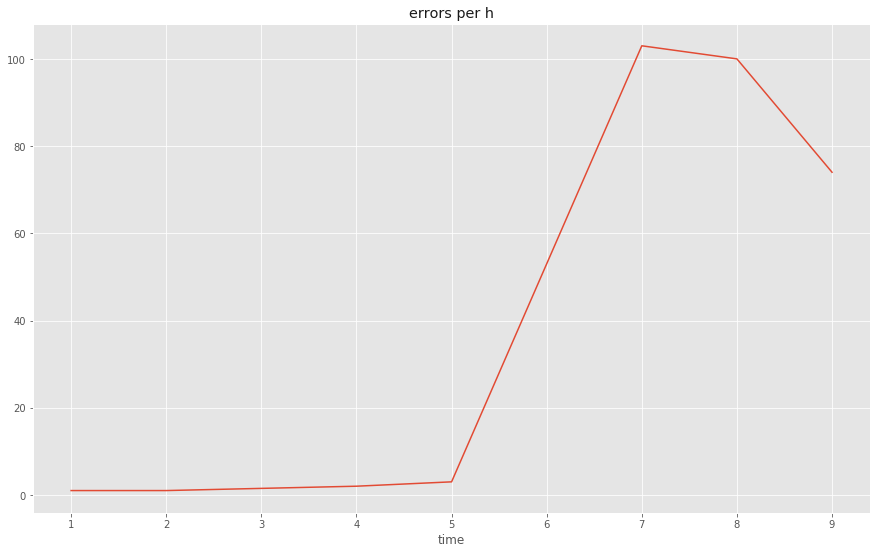

In [21]:
vusers['0009'].plot_user_errors('h') #, plot_params={'kind': 'line', 'figsize': (15, 9)})

---------------------------------------------------

In [22]:
period = 'h'
udf = vusers['0009'].show_errors()
udf.index = pd.to_datetime(udf.time, errors='coerce')
udf.head(5)

,time,user,uj,step,cycle,error type,error cause,cause message/ddi
time,,,,,,,,
2018-01-29 01:46:29,2018-01-29 01:46:29,0009,Open and Assign CM WO as Supervisor,Select WO,0,500,500,
2018-01-29 02:57:04,2018-01-29 02:57:04,0009,Open and Assign CM WO as Supervisor,Save,46,Success Validation Failure,operation resulted in a table with zero rows,searchterm: Record has been saved.
2018-01-29 04:01:16,2018-01-29 04:01:16,0009,Open and Assign CM WO as Supervisor,Save,88,Success Validation Failure,Warning Message,BMXAA8229W - Record WORKORDER : Site=WW Work Orde...
2018-01-29 04:56:36,2018-01-29 04:56:36,0009,Open and Assign CM WO as Supervisor,Save,126,Success Validation Failure,Warning Message,BMXAA8229W - Record WORKORDER : Site=WW Work Orde...
2018-01-29 05:11:33,2018-01-29 05:11:33,0009,Open and Assign CM WO as Supervisor,Save,136,Success Validation Failure,Warning Message,BMXAA8229W - Record WORKORDER : Site=WW Work Orde...


In [23]:
udf[datetime(2018, 1, 29, 9, 40):]

,time,user,uj,step,cycle,error type,error cause,cause message/ddi
time,,,,,,,,
2018-01-29 09:40:21,2018-01-29 09:40:21,0009,Open and Assign CM WO as Supervisor,Select WO,512,Response DD Extraction Failure,Response DD Extraction Failure,Open and Assign CM WO as Supervisor ID 3
2018-01-29 09:41:00,2018-01-29 09:41:00,0009,Open and Assign CM WO as Supervisor,Select WO,513,Response DD Extraction Failure,Response DD Extraction Failure,Open and Assign CM WO as Supervisor ID 3
2018-01-29 09:41:26,2018-01-29 09:41:26,0009,Open and Assign CM WO as Supervisor,Select WO,514,Response DD Extraction Failure,Response DD Extraction Failure,Open and Assign CM WO as Supervisor ID 3
2018-01-29 09:42:08,2018-01-29 09:42:08,0009,Open and Assign CM WO as Supervisor,Select WO,515,Response DD Extraction Failure,Response DD Extraction Failure,Open and Assign CM WO as Supervisor ID 3
2018-01-29 09:42:35,2018-01-29 09:42:35,0009,Open and Assign CM WO as Supervisor,Select WO,516,Response DD Extraction Failure,Response DD Extraction Failure,Open and Assign CM WO as Supervisor ID 3


In [24]:
try:
    udf[datetime(2018, 1, 29, 9, 41, 26)]
except KeyError:
    print('KeyError: datetime.datetime(2018, 1, 29, 9, 41, 26)')

KeyError: datetime.datetime(2018, 1, 29, 9, 41, 26)


In [25]:
try:
    udf[pd.to_datetime('2018-01-29 09:41:26', errors='coerce')]
except KeyError:
    print("KeyError: Timestamp('2018-01-29 09:41:26')")

KeyError: Timestamp('2018-01-29 09:41:26')


In [26]:
udf[datetime(2018, 1, 29, 9, 41, 26):datetime(2018, 1, 29, 9, 41, 27)]

,time,user,uj,step,cycle,error type,error cause,cause message/ddi
time,,,,,,,,
2018-01-29 09:41:26,2018-01-29 09:41:26,0009,Open and Assign CM WO as Supervisor,Select WO,514,Response DD Extraction Failure,Response DD Extraction Failure,Open and Assign CM WO as Supervisor ID 3


It seems to be working. The key factors are:
* errors='coerce'
* udf.index = 
* lookup references should be done by range of datetimes !

The double rows for column names is rather a quirk of the "pretty print" in Jupyter, since `udf.columns.nlevels` returns 1

In [27]:
udf.columns.nlevels

1

-----------------------------------------

In [28]:
# from pandas.tseries import converter as pdtc
# import matplotlib.units as munits
# import numpy as np

# munits.registry[np.datetime64] = pdtc.DatetimeConverter()

In [29]:
def plotit(df, plot_params):
    
    fig, ax1 = plt.subplots()

    # ax2 = ax1.twinx()
    ax1.plot(df.index, df['user'], 'b-')
    # ax2.plot(df.index, df['distance'], 'b-')

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Errors', color='b')
    # ax2.set_ylabel('Distance', color='g')


    plt.show()
    plt.rcParams['figure.figsize'] = 15,9
    # df.plot(**plot_params);

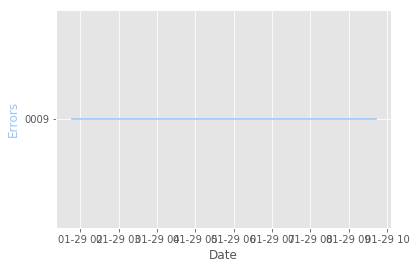

In [30]:
period = 'h'
plot_params = {'kind': 'bar', 'title' : 'errors per ' + period, 'figsize': (15, 9) }#  'style': ['-.'], }
plotit(udf, plot_params)

In [31]:
hdf = pd.DataFrame()
hdf['user'] = udf.user.resample('H').count()
hdf

,user
time,
2018-01-29 01:00:00,1
2018-01-29 02:00:00,1
2018-01-29 03:00:00,0
2018-01-29 04:00:00,2
2018-01-29 05:00:00,3
2018-01-29 06:00:00,53
2018-01-29 07:00:00,103
2018-01-29 08:00:00,100
2018-01-29 09:00:00,74


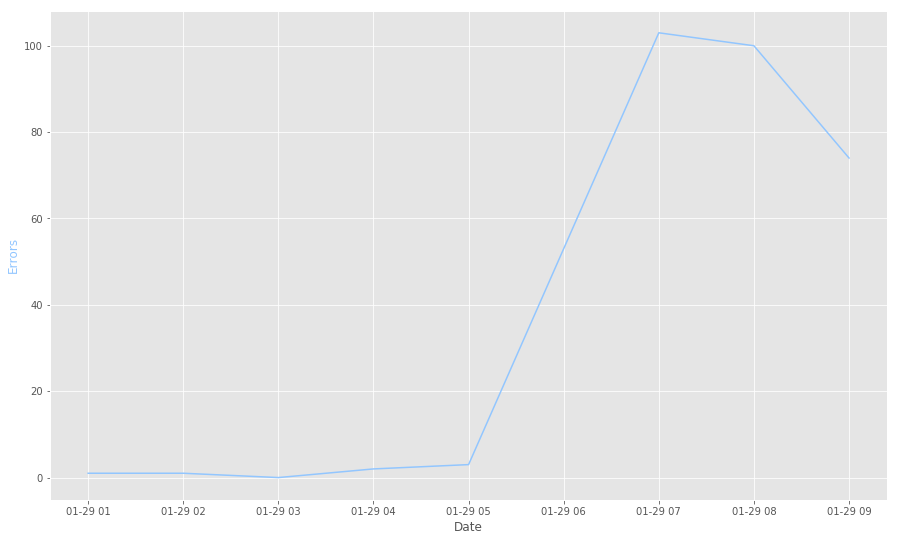

In [32]:
plotit(hdf, None)

In [33]:
def barit(df, bar_width_apparently_in_days=0.04):
    
    print('bar width:', bar_width_apparently_in_days)
    
    fig, ax1 = plt.subplots()

    # ax2 = ax1.twinx()
    ax1.bar(df.index, df['user'], width=bar_width_apparently_in_days, color='b') #, ec='r')
    # ax2.plot(df.index, df['distance'], 'b-')

    ax1.set_xlabel('Time')
    ax1.set_ylabel('Errors', color='b')
    # ax2.set_ylabel('Distance', color='g')
    
    #set ticks every week
    if bar_width_apparently_in_days > 0.001:
        ax1.xaxis.set_major_locator(mdates.HourLocator())
    else:
        ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval=15))
    
    #set major ticks format
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))


    plt.show()
    plt.rcParams['figure.figsize'] = 15,9
    # df.plot(**plot_params);

bar width: 0.04


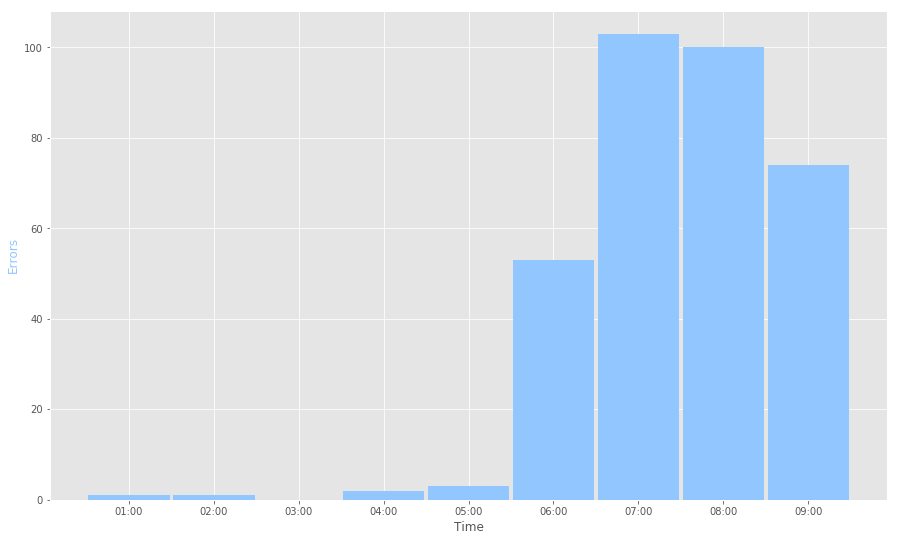

In [34]:
barit(hdf, )

In [35]:
mdf = pd.DataFrame()
mdf['user'] = udf.user.resample('T').count()
mdf.head()

,user
time,
2018-01-29 01:46:00,1
2018-01-29 01:47:00,0
2018-01-29 01:48:00,0
2018-01-29 01:49:00,0
2018-01-29 01:50:00,0


bar width: 0.04


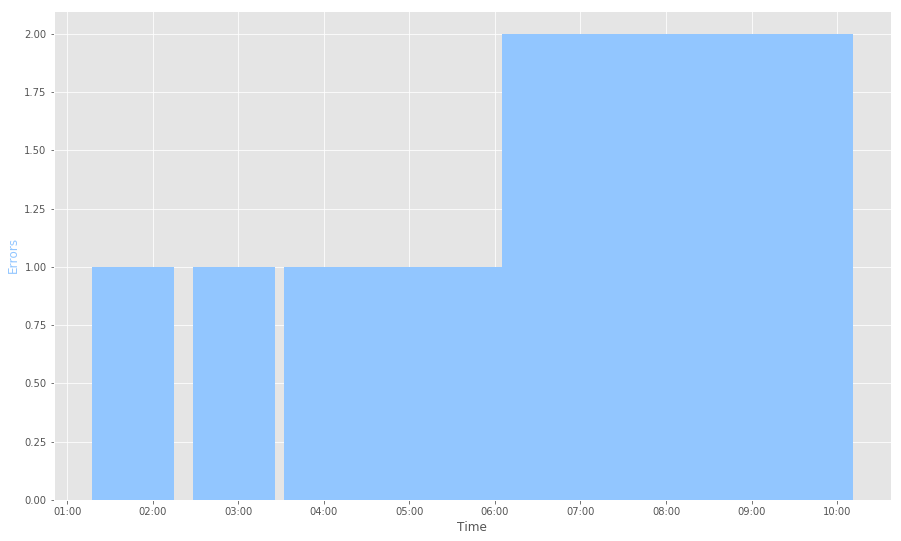

In [36]:
barit(mdf, )

bar width: 0.0006


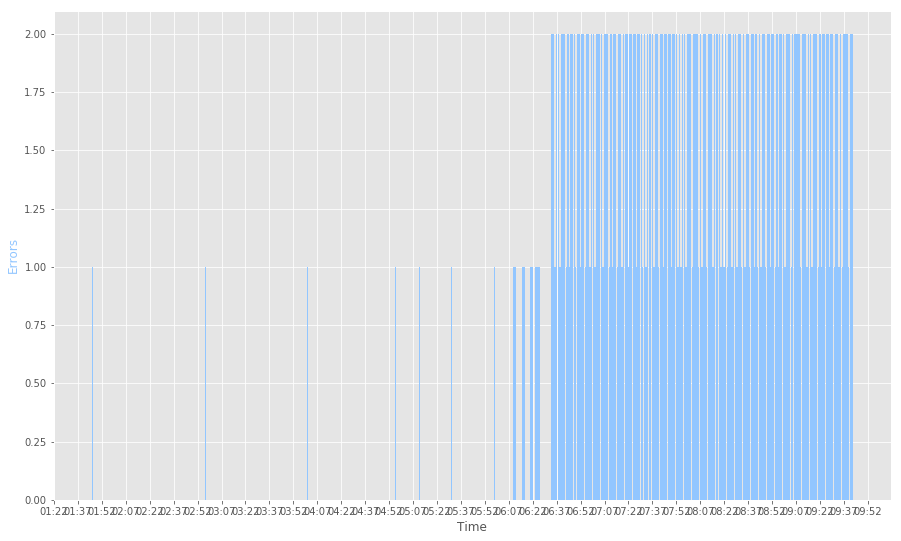

In [37]:
barit(mdf, 0.0006)

bar width: 0.0003


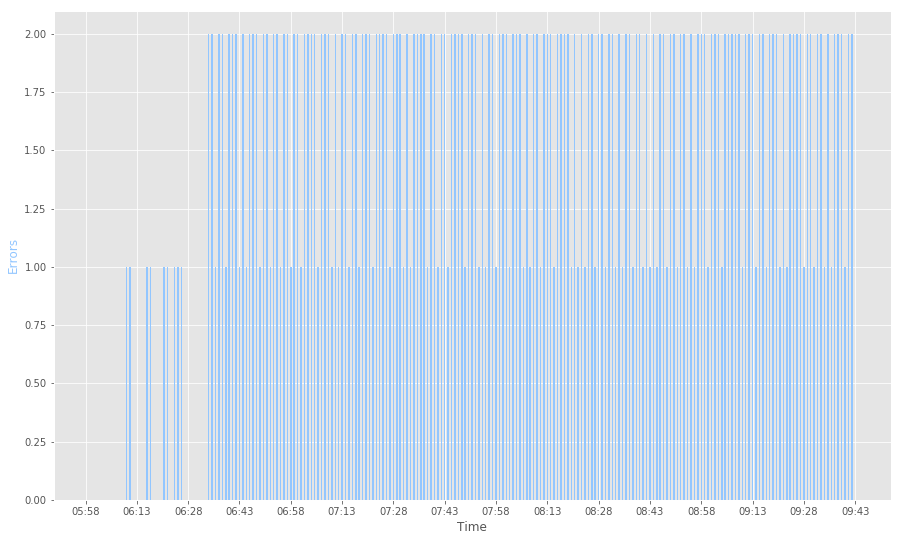

In [38]:
barit(mdf[datetime(2018, 1, 29, 6):], 0.0003) #datetime(2018, 1, 29, 9, 41, 27)

bar width: 0.0002


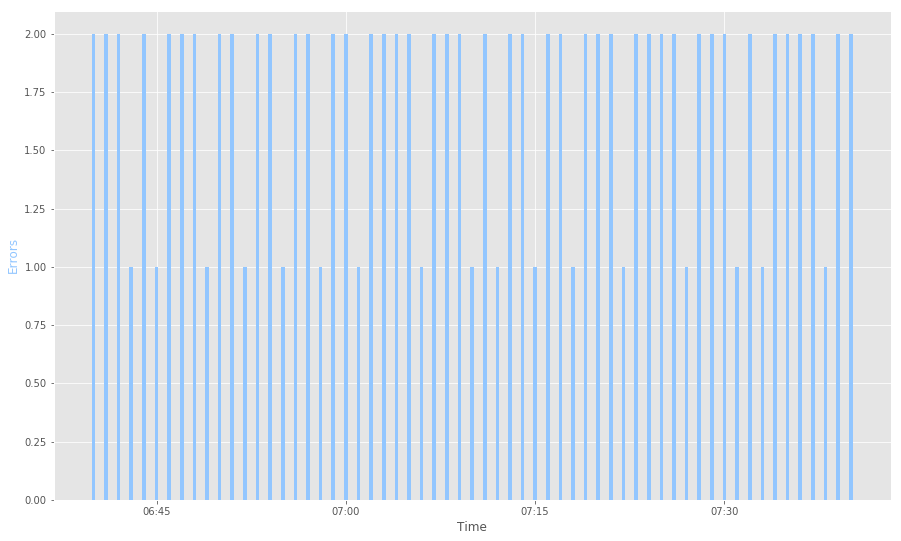

In [39]:
barit(mdf[datetime(2018, 1, 29, 6, 40):datetime(2018, 1, 29, 7, 40)], 0.0002)

------------------------------

Try Seaborn /sns

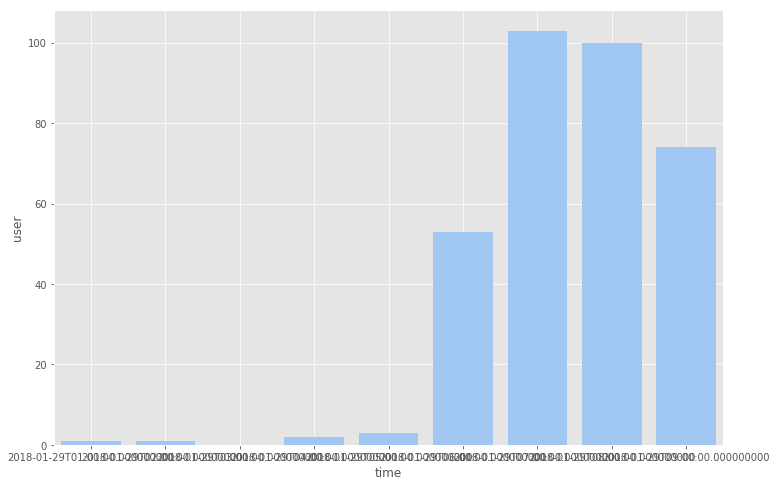

In [40]:
plt.figure(figsize=(12,8))
sns.barplot(hdf.index, hdf.user, color="b")
plt.grid(True)
plt.show()

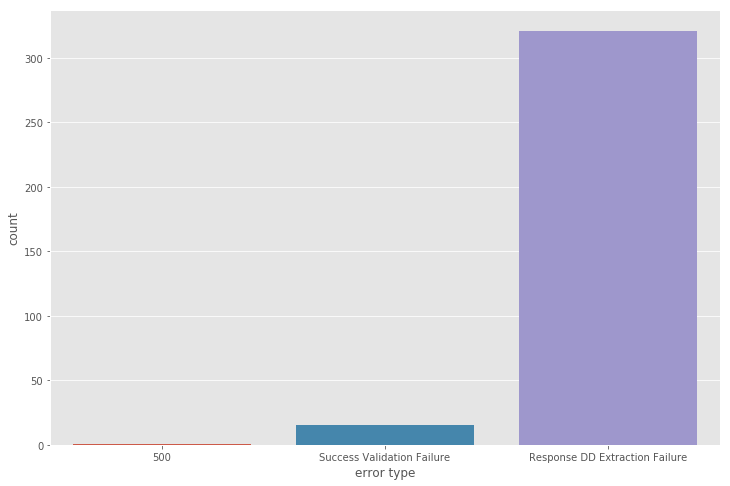

In [41]:
f, ax = plt.subplots(figsize=(12,8))
sns.countplot('error type', data=udf) #, size=6, aspect=1.5)#, ax=ax[0,0])
# sns.factorplot( x=udf.user, data=udf, kind="count", size=6, aspect=1.5)#, ax=ax[0,0])
# ax.set_xticklabels('errors') #, step=2)

The next example from Seaborn gallery differs from what I need:
* "time" (i.e. "year") in the planets dataset is not an index, rather a category
* ultimately I want to count individual error types, rather than just the total errors

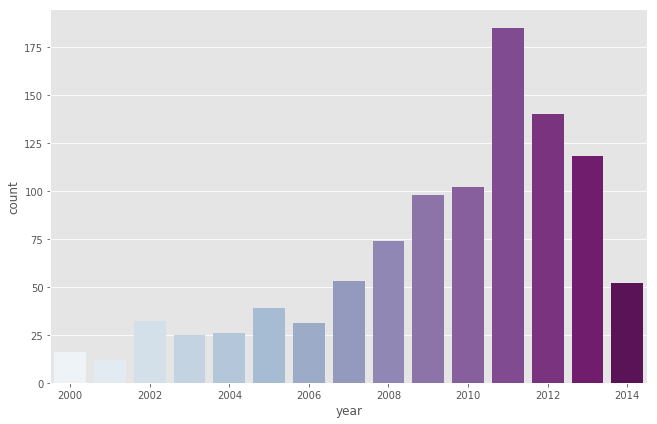

In [42]:
planets = sns.load_dataset("planets")
planets.head()

years = np.arange(2000, 2015)
g = sns.factorplot(x="year", data=planets, kind="count",
                   palette="BuPu", size=6, aspect=1.5, order=years)
g.set_xticklabels(step=2)

In [43]:
udf.head()

,time,user,uj,step,cycle,error type,error cause,cause message/ddi
time,,,,,,,,
2018-01-29 01:46:29,2018-01-29 01:46:29,0009,Open and Assign CM WO as Supervisor,Select WO,0,500,500,
2018-01-29 02:57:04,2018-01-29 02:57:04,0009,Open and Assign CM WO as Supervisor,Save,46,Success Validation Failure,operation resulted in a table with zero rows,searchterm: Record has been saved.
2018-01-29 04:01:16,2018-01-29 04:01:16,0009,Open and Assign CM WO as Supervisor,Save,88,Success Validation Failure,Warning Message,BMXAA8229W - Record WORKORDER : Site=WW Work Orde...
2018-01-29 04:56:36,2018-01-29 04:56:36,0009,Open and Assign CM WO as Supervisor,Save,126,Success Validation Failure,Warning Message,BMXAA8229W - Record WORKORDER : Site=WW Work Orde...
2018-01-29 05:11:33,2018-01-29 05:11:33,0009,Open and Assign CM WO as Supervisor,Save,136,Success Validation Failure,Warning Message,BMXAA8229W - Record WORKORDER : Site=WW Work Orde...


In [44]:
hdf = pd.DataFrame()
hdf['user'] = udf.user.resample('H').count()
hdf

,user
time,
2018-01-29 01:00:00,1
2018-01-29 02:00:00,1
2018-01-29 03:00:00,0
2018-01-29 04:00:00,2
2018-01-29 05:00:00,3
2018-01-29 06:00:00,53
2018-01-29 07:00:00,103
2018-01-29 08:00:00,100
2018-01-29 09:00:00,74


In [45]:
tmpdf = pd.DataFrame()
tmpdf['error type'] = udf['error type']
tmpdf['cycle'] = udf['cycle'].astype(int)
tmpdf

,error type,cycle
time,,
2018-01-29 01:46:29,500,0
2018-01-29 02:57:04,Success Validation Failure,46
2018-01-29 04:01:16,Success Validation Failure,88
2018-01-29 04:56:36,Success Validation Failure,126
2018-01-29 05:11:33,Success Validation Failure,136
2018-01-29 05:31:07,Success Validation Failure,150
2018-01-29 05:58:38,Success Validation Failure,169
2018-01-29 06:10:28,Success Validation Failure,177
2018-01-29 06:11:47,Success Validation Failure,178


The ".groupby" works as follows: creates sor of "dictionary" (DataFrameGroupBy object) with keys matching the groups, and each value in the dictionary is a DataFrame with the corresponding rows from the original DF.

In [46]:
grouped_df = tmpdf.groupby('error type')
for key, item in grouped_df:
    print(grouped_df.get_group(key), '\n\n')

                    error type  cycle
time                                 
2018-01-29 01:46:29        500      0 


                                         error type  cycle
time                                                      
2018-01-29 06:34:15  Response DD Extraction Failure    196
2018-01-29 06:34:44  Response DD Extraction Failure    197
2018-01-29 06:35:24  Response DD Extraction Failure    198
2018-01-29 06:35:51  Response DD Extraction Failure    199
2018-01-29 06:36:24  Response DD Extraction Failure    200
2018-01-29 06:37:05  Response DD Extraction Failure    201
2018-01-29 06:37:38  Response DD Extraction Failure    202
2018-01-29 06:38:12  Response DD Extraction Failure    203
2018-01-29 06:38:52  Response DD Extraction Failure    204
2018-01-29 06:39:32  Response DD Extraction Failure    205
2018-01-29 06:40:02  Response DD Extraction Failure    206
2018-01-29 06:40:37  Response DD Extraction Failure    207
2018-01-29 06:41:09  Response DD Extraction Failure    20

Applying a function to the DataFrameGroupBy object, causes it to be "reduced" to a regular DataFrame - prior dict keys are now indexes and the rows values are collapsed

In [47]:
summed = grouped_df.sum()
print(type(summed))
summed

<class 'pandas.core.frame.DataFrame'>


,cycle
error type,
500,0
Response DD Extraction Failure,114276
Success Validation Failure,2375


Applying `.resample(<period_encoding>)`, generally results in object that cannot be directly viewed (yet has index). Only after applyng additional function, the resulting object is a Dataframe.

In [48]:
resampled = tmpdf.resample('H')
print(resampled.index)
# resampled.loc[resampled.index[0]]
# resampled.iloc[0]

resampled_mean = tmpdf.resample('H').mean()
resampled_mean

DatetimeIndex(['2018-01-29 01:00:00', '2018-01-29 02:00:00',
               '2018-01-29 03:00:00', '2018-01-29 04:00:00',
               '2018-01-29 05:00:00', '2018-01-29 06:00:00',
               '2018-01-29 07:00:00', '2018-01-29 08:00:00',
               '2018-01-29 09:00:00'],
              dtype='datetime64[ns]', name='time', freq='H')


/home/bob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  


,cycle
time,
2018-01-29 01:00:00,0.000000
2018-01-29 02:00:00,46.000000
2018-01-29 03:00:00,NaN
2018-01-29 04:00:00,107.000000
2018-01-29 05:00:00,151.666667
2018-01-29 06:00:00,211.886792
2018-01-29 07:00:00,291.000000
2018-01-29 08:00:00,392.500000
2018-01-29 09:00:00,479.500000


Applying `.resample()` on top of a grouped object, gives a DatetimeIndexResamplerGroupby object. The key difference is that now there is MuliIndex.

In [49]:
resampled = grouped_df.resample('H')
print(resampled.index)
resampled_mean = grouped_df.resample('H').mean()
resampled_mean

MultiIndex(levels=[['500', 'Response DD Extraction Failure', 'Success Validation Failure'], [2018-01-29 01:00:00, 2018-01-29 02:00:00, 2018-01-29 03:00:00, 2018-01-29 04:00:00, 2018-01-29 05:00:00, 2018-01-29 06:00:00, 2018-01-29 07:00:00, 2018-01-29 08:00:00, 2018-01-29 09:00:00]],
           labels=[[0, 1, 1, 1, 1, 2, 2, 2, 2, 2], [0, 5, 6, 7, 8, 1, 2, 3, 4, 5]],
           names=['error type', 'time'])


/home/bob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  


cycle
error type                     time                           
500                            2018-01-29 01:00:00    0.000000
Response DD Extraction Failure 2018-01-29 06:00:00  217.500000
                               2018-01-29 07:00:00  291.000000
                               2018-01-29 08:00:00  392.500000
                               2018-01-29 09:00:00  479.500000
Success Validation Failure     2018-01-29 02:00:00   46.000000
                               2018-01-29 03:00:00         NaN
                               2018-01-29 04:00:00  107.000000
                               2018-01-29 05:00:00  151.666667
                               2018-01-29 06:00:00  184.444444

In [50]:
ndf = tmpdf.groupby('error type').resample('H').count().unstack('error type')
ndf

error type                                 \
error type                 500 Response DD Extraction Failure   
time                                                            
2018-01-29 01:00:00        1.0                            NaN   
2018-01-29 02:00:00        NaN                            NaN   
2018-01-29 03:00:00        NaN                            NaN   
2018-01-29 04:00:00        NaN                            NaN   
2018-01-29 05:00:00        NaN                            NaN   
2018-01-29 06:00:00        NaN                           44.0   
2018-01-29 07:00:00        NaN                          103.0   
2018-01-29 08:00:00        NaN                          100.0   
2018-01-29 09:00:00        NaN                           74.0   

                                               cycle  \
error type          Success Validation Failure   500   
time                                                   
2018-01-29 01:00:00                        NaN   1.0   
2018-01-29 02:00:00                        1.0   NaN   
2018-01-29 03:00:00                        0.0   NaN   
2018-01-29 04:00:00                        2.0   NaN   
2018-01-29 05:00:00                        3.0   NaN   
2018-01-29 06:00:00                        9.0   NaN   
2018-01-29 07:00:00                        NaN   NaN   
2018-01-29 08:00:00                        NaN   NaN   
2018-01-29 09:00:00                        NaN   NaN   

                                                                               
error type          Response DD Extraction Failure Success Validation Failure  
time                                                                           
2018-01-29 01:00:00                            NaN                        NaN  
2018-01-29 02:00:00                            NaN                        1.0  
2018-01-29 03:00:00                            NaN                        0.0  
2018-01-29 04:00:00                            NaN                        2.0  
2018-01-29 05:00:00                            NaN                        3.0  
2018-01-29 06:00:00                           44.0                        9.0  
2018-01-29 07:00:00                          103.0                        NaN  
2018-01-29 08:00:00                          100.0                        NaN  
2018-01-29 09:00:00                           74.0                        NaN

The above case where we used the cycle as nummeric value is not ideal - changing to just error_type

In [51]:
tmpdf = pd.DataFrame()
tmpdf['error type'] = udf['error type']
tmpdf

,error type
time,
2018-01-29 01:46:29,500
2018-01-29 02:57:04,Success Validation Failure
2018-01-29 04:01:16,Success Validation Failure
2018-01-29 04:56:36,Success Validation Failure
2018-01-29 05:11:33,Success Validation Failure
2018-01-29 05:31:07,Success Validation Failure
2018-01-29 05:58:38,Success Validation Failure
2018-01-29 06:10:28,Success Validation Failure
2018-01-29 06:11:47,Success Validation Failure


Here `.unstack()` "pivots" the index based on the error_type values to columns

In [52]:
ndf = tmpdf.groupby('error type').resample('H').count().unstack('error type')
ndf

error type                                 \
error type                 500 Response DD Extraction Failure   
time                                                            
2018-01-29 01:00:00        1.0                            NaN   
2018-01-29 02:00:00        NaN                            NaN   
2018-01-29 03:00:00        NaN                            NaN   
2018-01-29 04:00:00        NaN                            NaN   
2018-01-29 05:00:00        NaN                            NaN   
2018-01-29 06:00:00        NaN                           44.0   
2018-01-29 07:00:00        NaN                          103.0   
2018-01-29 08:00:00        NaN                          100.0   
2018-01-29 09:00:00        NaN                           74.0   

                                                
error type          Success Validation Failure  
time                                            
2018-01-29 01:00:00                        NaN  
2018-01-29 02:00:00                        1.0  
2018-01-29 03:00:00                        0.0  
2018-01-29 04:00:00                        2.0  
2018-01-29 05:00:00                        3.0  
2018-01-29 06:00:00                        9.0  
2018-01-29 07:00:00                        NaN  
2018-01-29 08:00:00                        NaN  
2018-01-29 09:00:00                        NaN

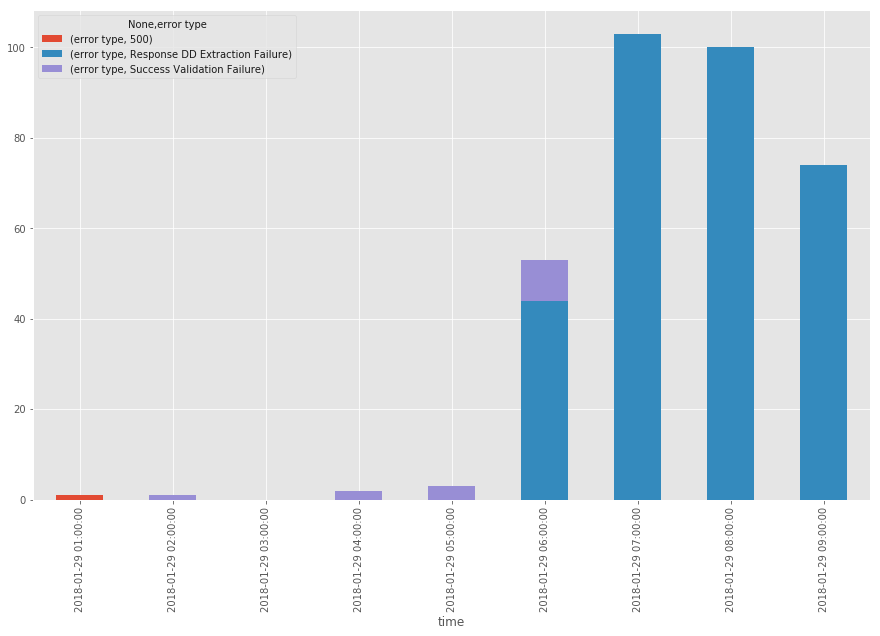

In [53]:
ndf.plot.bar(stacked=True)

In [54]:
def bar_categorical(udf, feature, freq='H'):
    tmpdf = pd.DataFrame()
    tmpdf[feature] = udf[feature]
    ndf = tmpdf.groupby(feature).resample(freq).count().unstack(feature)
    ndf.plot.bar(stacked=True)

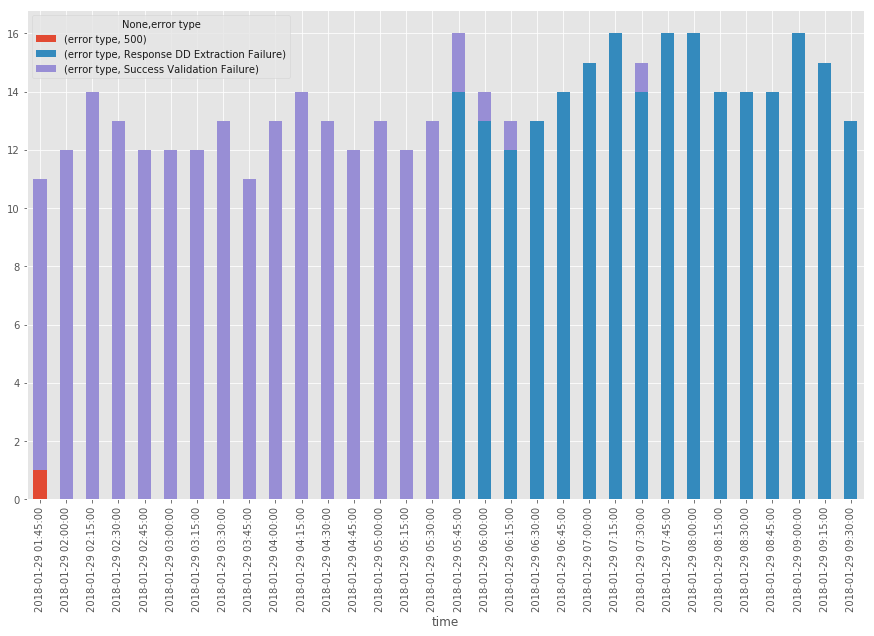

In [55]:
udf = vusers['0014'].show_errors()
udf.index = pd.to_datetime(udf.time, errors='coerce')
bar_categorical(udf, 'error type', '15T')

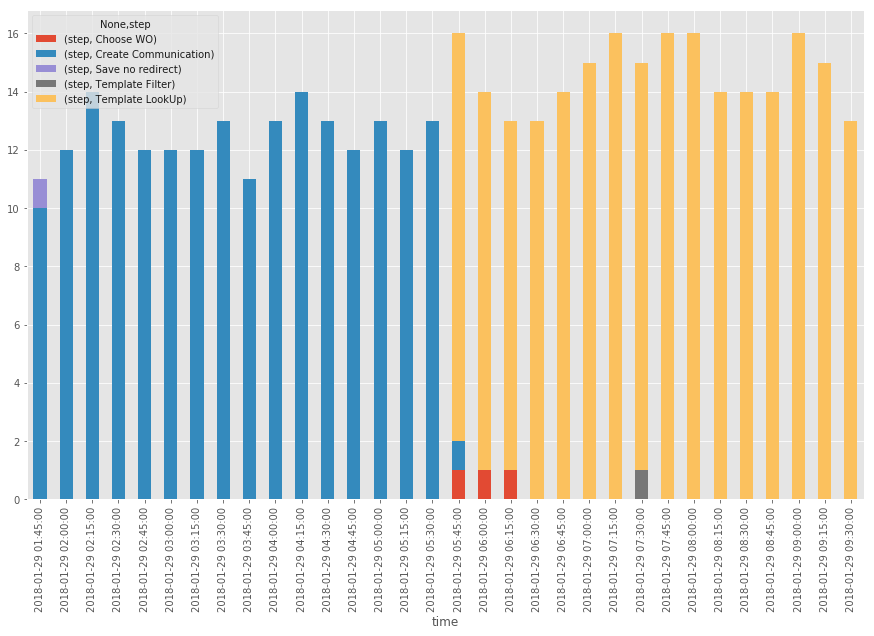

In [56]:
bar_categorical(udf, 'step', '15T')

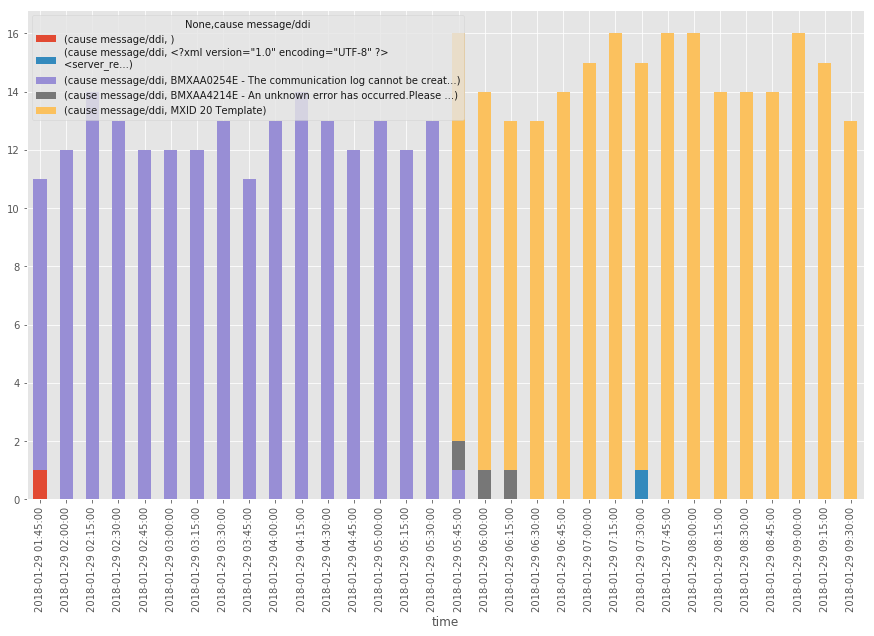

In [57]:
bar_categorical(udf, 'cause message/ddi', '15T')